In [1]:
import json
import os, sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pprint import pp
from typing import Tuple, List, Dict, Any
from datasets.arc_dataset_v2 import ArcTaskDataset, collate_task_pairs
from matplotlib import pyplot as plt
from pprint import pprint
import models
from tqdm import tqdm
import copy

In [2]:
dataset = ArcTaskDataset("../data/arc-agi_training_challenges.json", "../data/arc-agi_training_solutions.json")

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# ARC uses 10 colors (0-9), but you mentioned 0-11
# Create a discrete colormap with distinct colors
arc_colors = ["#F48DF4", "#059999", '#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00', 
              '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF',
              '#FFFFFF', ]  # Extended for 0-11

def visualize_grid(grid, title=""):
    """Visualize an ARC grid with discrete colors and optional grid lines"""
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Create discrete colormap
    cmap = mcolors.ListedColormap(arc_colors[:12])
    bounds = np.arange(-0.5, 12, 1)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    # Display the grid
    im = ax.imshow(grid, cmap=cmap, norm=norm)
    
    # Add grid lines
    ax.set_xticks(np.arange(-0.5, grid.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, grid.shape[0], 1), minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
    ax.tick_params(which="minor", size=0)
    
    ax.set_title(title)
    plt.colorbar(im, ax=ax, ticks=range(12))
    plt.tight_layout()
    return fig, ax

dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=1, collate_fn=collate_task_pairs, prefetch_factor=4, drop_last=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# encoder = models.GridEncoder(d_model=1024, num_layers=3, nhead=8, d_colors=1024, nlayer_mlp=3)
# decoder = models.GridDecoder(num_layers=5, d_colors=1024)
# optimizer = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)

model = models.BestCAE32(in_ch=12, base=64, out_ch=120, n_res=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


In [ ]:
loss_history = []
loss_fn = nn.CrossEntropyLoss()
for epoch in range(100):
    pbar = tqdm(dataloader, desc="Training", total=len(dataloader))
    for data in pbar:
        z_task = model.z_init_task
        y_task = model.y_init_task
        z_solution = model.z_init_solution
        y_solution = model.y_init_solution
        z_task_nograd = z_task.detach()
        y_task_nograd = y_task.detach()
        z_solution_nograd = z_solution.detach()
        y_solution_nograd = y_solution.detach()
        # print(data[1])
        optimizer.zero_grad()
        m_nograd = copy.deepcopy(model)
        for p in m_nograd.parameters():
                    p.requires_grad_(False)

        data_split1, data_split2 = data[1][:, 0], data[1][:, 1]
        inputs1_one_hot = nn.functional.one_hot(torch.tensor(data_split1[:, : ,:, 0], dtype=torch.int64), num_classes=12).float().permute(0, 3, 1, 2).to(device)
        inputs2_one_hot = nn.functional.one_hot(torch.tensor(data_split2[:, : ,:, 0], dtype=torch.int64), num_classes=12).float().permute(0, 3, 1, 2).to(device)
        outputs1_one_hot = nn.functional.one_hot(torch.tensor(data_split1[:, : ,:, 1], dtype=torch.int64), num_classes=12).float().permute(0, 3, 1, 2).to(device)
        outputs2_one_hot = nn.functional.one_hot(torch.tensor(data_split2[:, : ,:, 1], dtype=torch.int64), num_classes=12).float().permute(0, 3, 1, 2).to(device)
        task1_one_hot = torch.cat([inputs1_one_hot, outputs1_one_hot], dim=1)
        task2_one_hot = torch.cat([inputs2_one_hot, outputs2_one_hot], dim=1)
        
        x = model.task_head(task1_one_hot)
        (z_task, y_task), y_hat, q_hat = model.deep_recursion(x, y_task, z_task, 6, 3)
        
        x = m_nograd.task_head(task2_one_hot)
        (z_solution_nograd, y_solution_nograd), y_hat, q_hat = m_nograd.deep_recursion(x, y_solution_nograd, z_solution_nograd, 6, 3, y_hat)
        loss = loss_fn(y_hat, torch.argmax(outputs2_one_hot, dim=1))

        # loss = loss_fn(decoded_out, inputs_tensor)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        x = m_nograd.task_head(task1_one_hot)
        (z_task_nograd, y_task_nograd), y_hat, q_hat = m_nograd.deep_recursion(x, y_task_nograd, z_task_nograd, 6, 3)
        (z_solution, y_solution), y_hat, q_hat = model.deep_recursion(x, y_solution, z_solution, 6, 3, y_hat)
        loss2 = loss_fn(y_hat, torch.argmax(outputs1_one_hot, dim=1))
        loss2.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_history.append((loss.item()+loss2.item())/2)
        pbar.set_postfix({"loss": (loss.item()+loss2.item())/2})


        # break

        # loss_history.append(loss.item())
        # pbar.set_postfix({"loss": loss.item()})

Training:  33%|███▎      | 1/3 [00:12<00:25, 12.80s/it, loss=0.45]

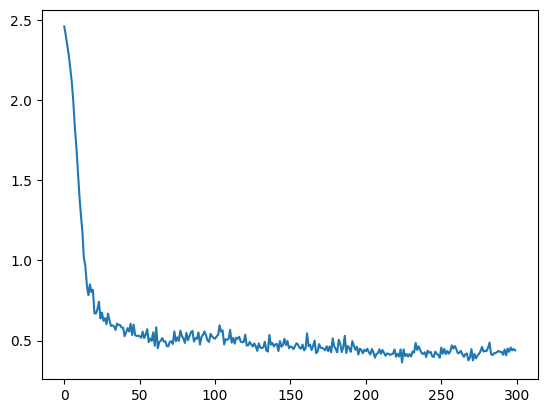

In [5]:
plt.plot(loss_history)

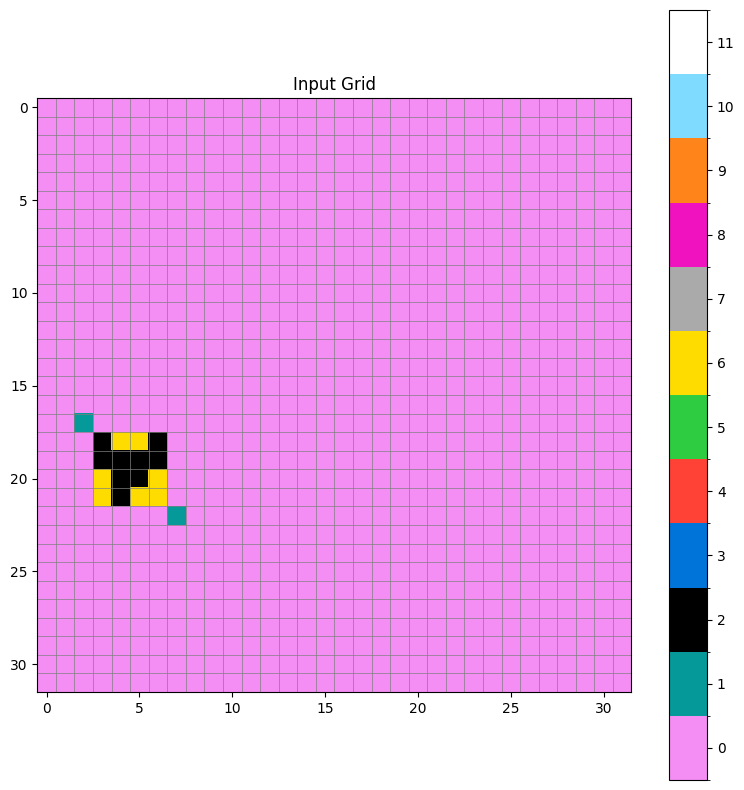

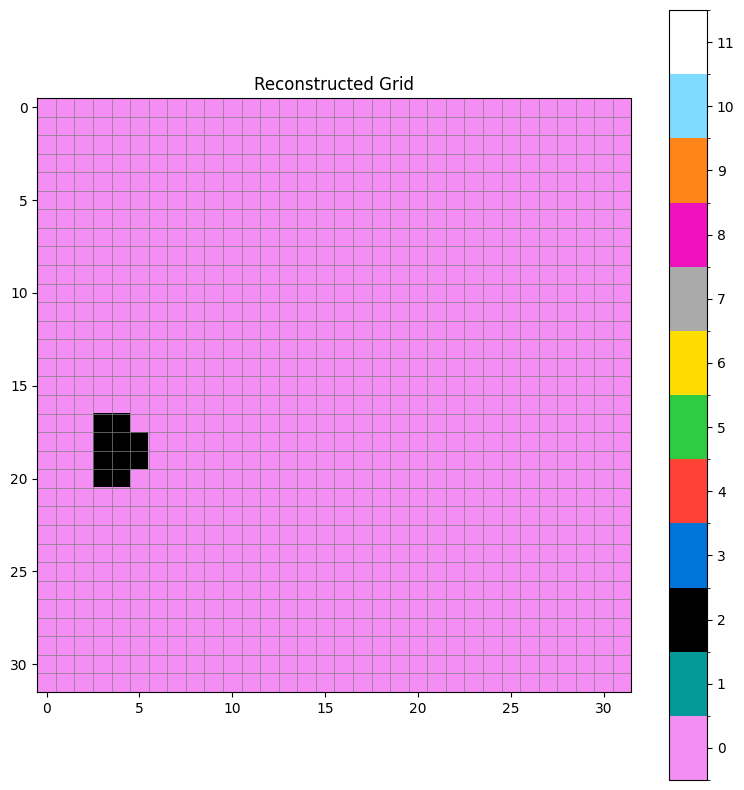

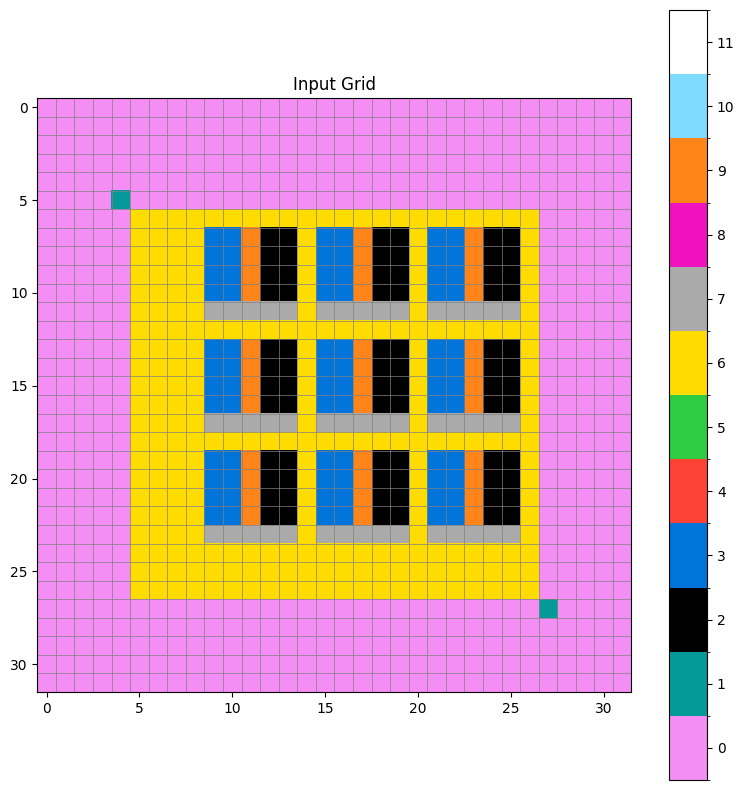

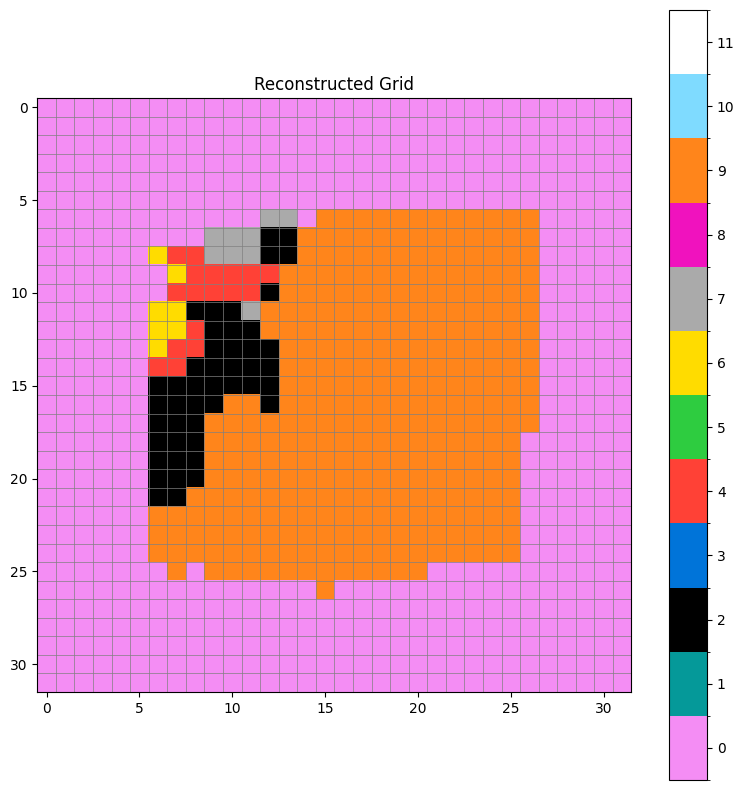

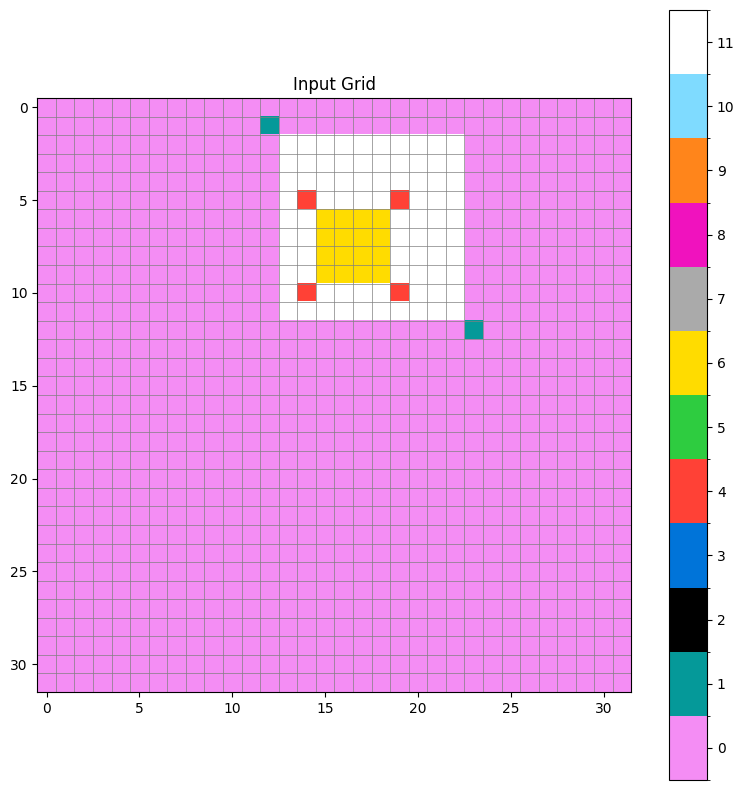

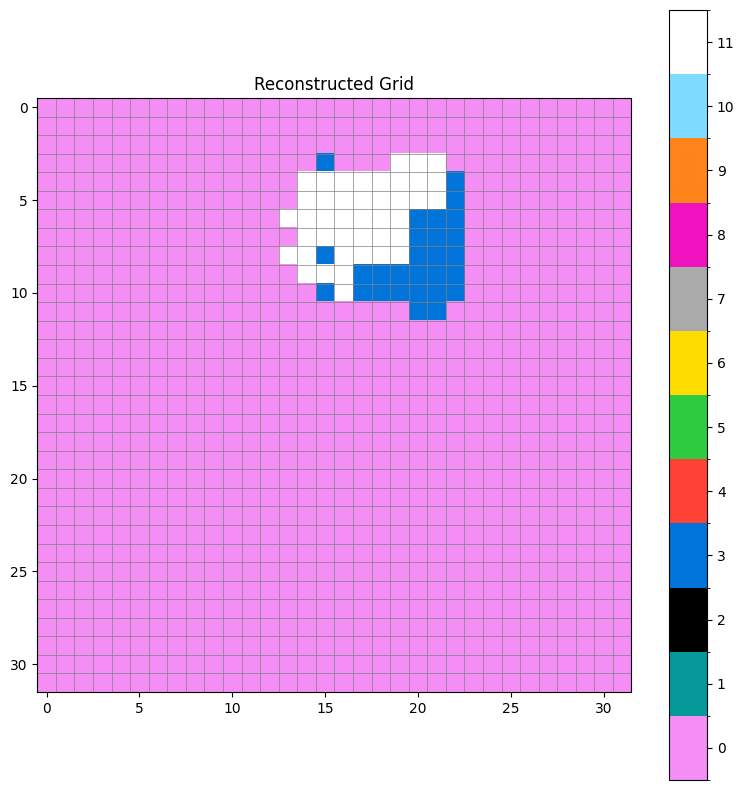

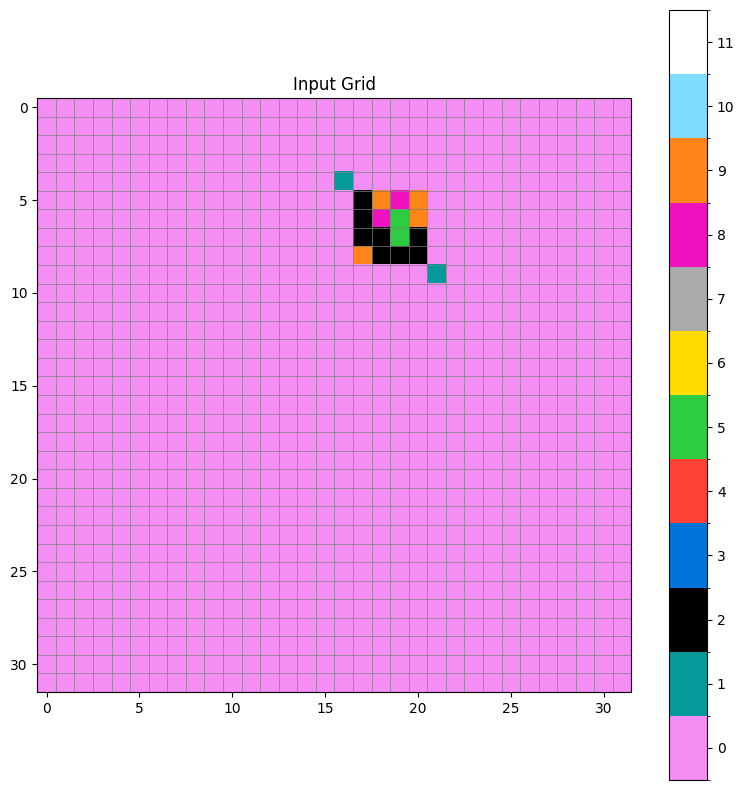

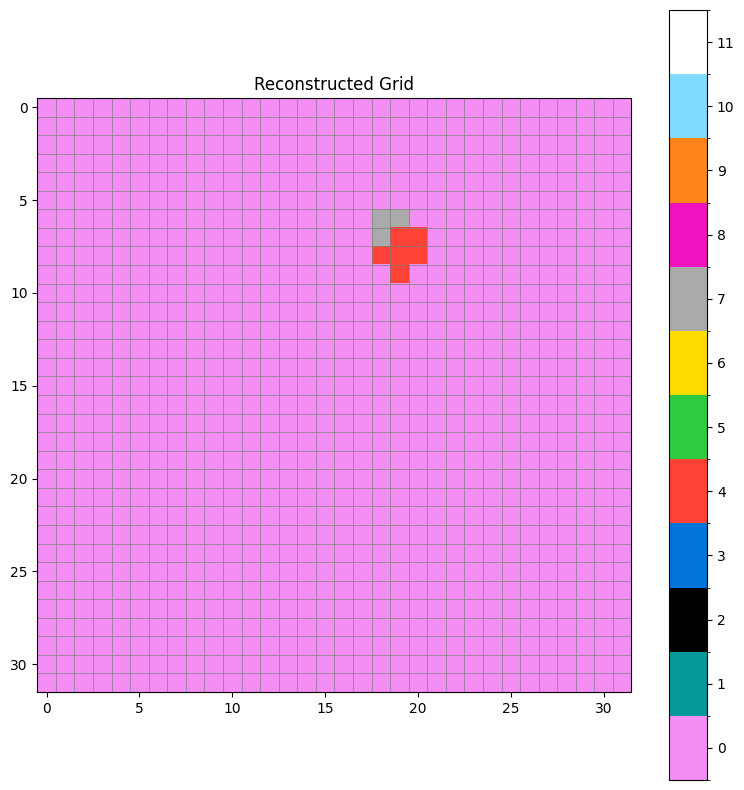

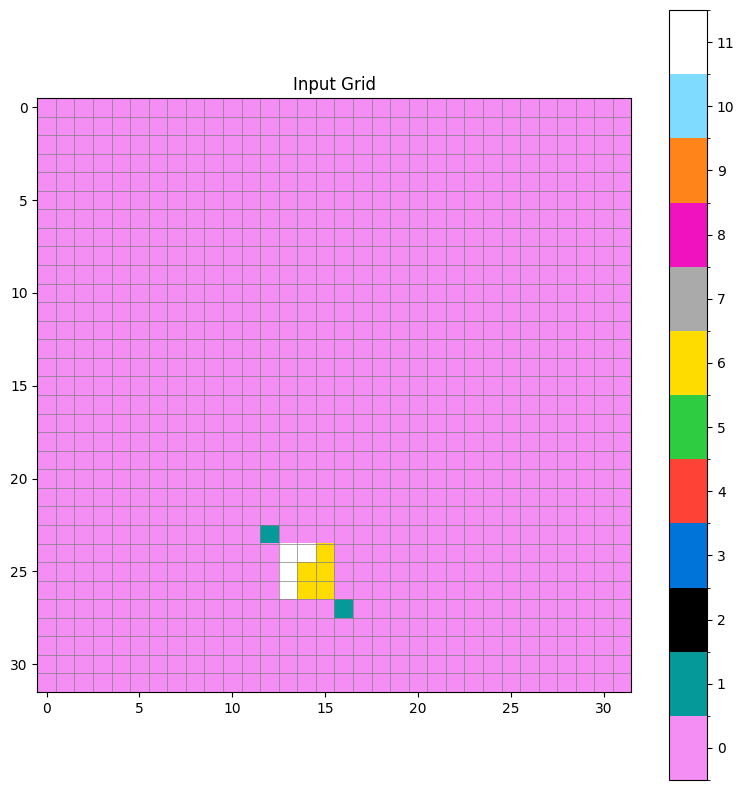

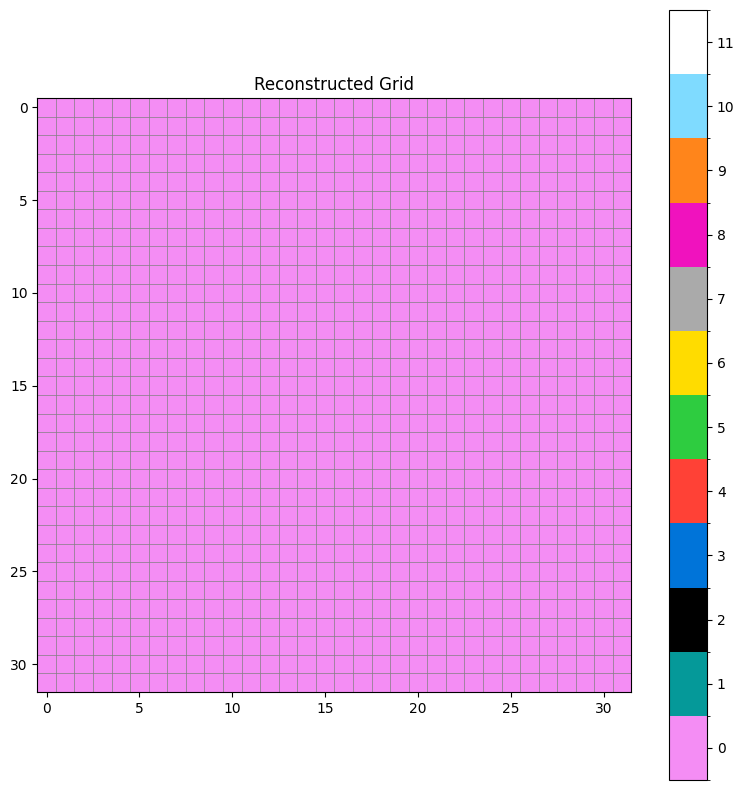

In [6]:
for i in range(len(data_split1[:, : ,:, 1])):
    visualize_grid(data_split1[:, : ,:, 1][i], title="Input Grid")
    visualize_grid(torch.argmax(y_hat[i], dim=0).cpu().numpy(), title="Reconstructed Grid")
    if i == 4:
        break